In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-04-23 21:12:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-23 21:12:15 (93.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "/content/drive/MyDrive/pest classification"
walk_through_dir(dataset)

There are 12 directories and 0 images in '/content/drive/MyDrive/pest classification'.
There are 0 directories and 498 images in '/content/drive/MyDrive/pest classification/wasp'.
There are 0 directories and 466 images in '/content/drive/MyDrive/pest classification/earwig'.
There are 0 directories and 500 images in '/content/drive/MyDrive/pest classification/bees'.
There are 0 directories and 391 images in '/content/drive/MyDrive/pest classification/slug'.
There are 0 directories and 485 images in '/content/drive/MyDrive/pest classification/grasshopper'.
There are 0 directories and 500 images in '/content/drive/MyDrive/pest classification/snail'.
There are 0 directories and 485 images in '/content/drive/MyDrive/pest classification/weevil'.
There are 0 directories and 497 images in '/content/drive/MyDrive/pest classification/moth'.
There are 0 directories and 434 images in '/content/drive/MyDrive/pest classification/catterpillar'.
There are 0 directories and 416 images in '/content/driv

In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [13]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/drive/MyDrive/pest classification").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

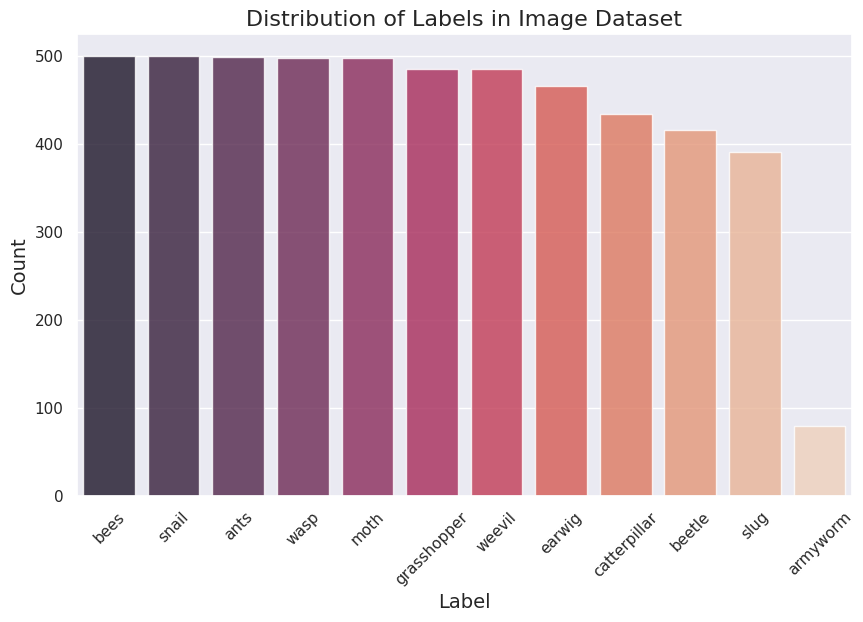

In [14]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()

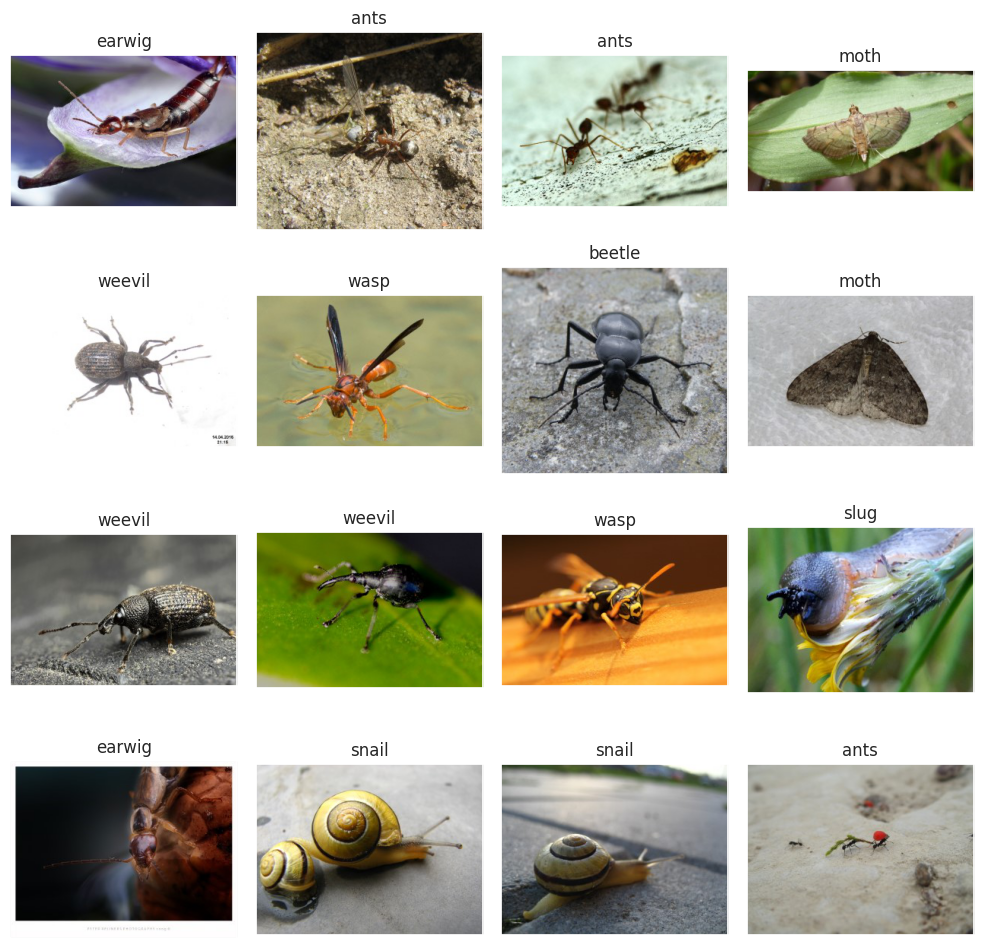

In [15]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [16]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()


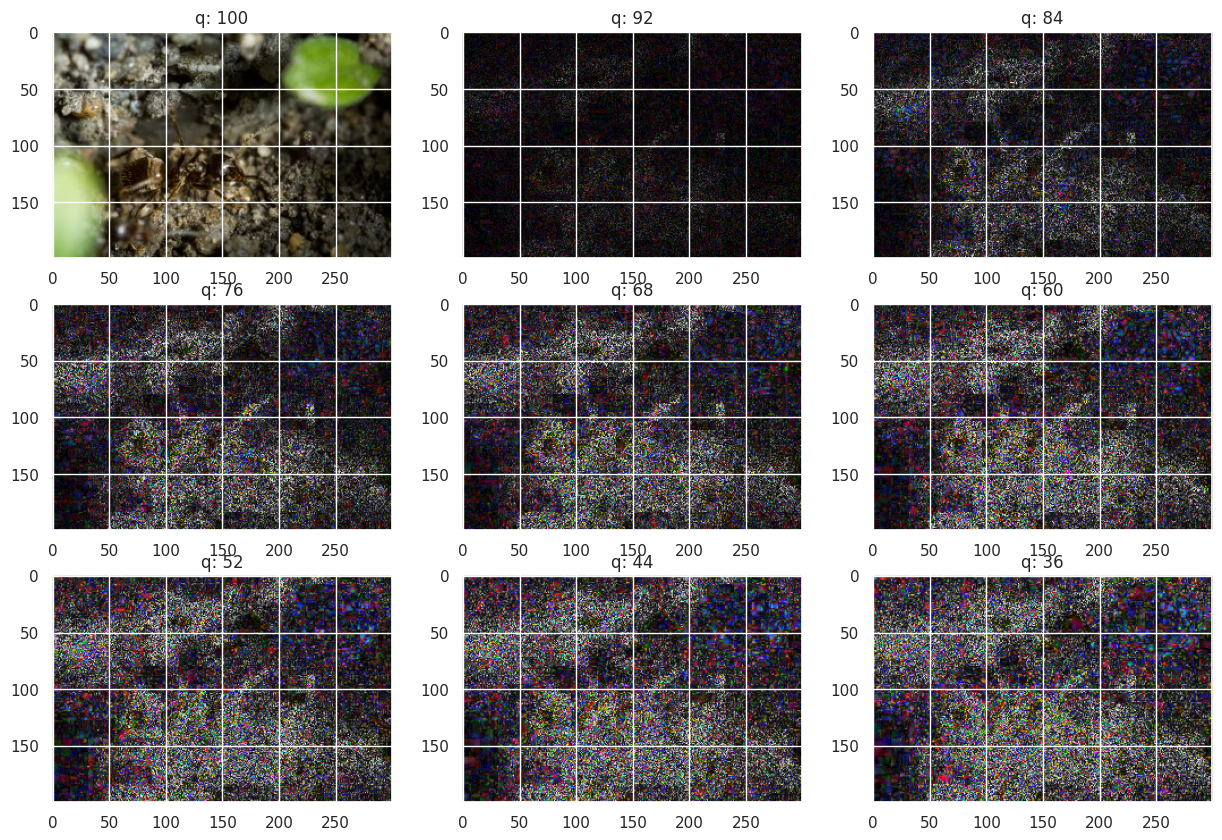

In [17]:
p = random_sample('/content/drive/MyDrive/pest classification/ants')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [18]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [19]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [20]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3360 validated image filenames belonging to 12 classes.
Found 840 validated image filenames belonging to 12 classes.
Found 1050 validated image filenames belonging to 12 classes.


In [21]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [22]:
labels

{0: 'ants',
 1: 'armyworm',
 2: 'bees',
 3: 'beetle',
 4: 'catterpillar',
 5: 'earwig',
 6: 'grasshopper',
 7: 'moth',
 8: 'slug',
 9: 'snail',
 10: 'wasp',
 11: 'weevil'}

In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

473176280/473176280 [==============================] - 3s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(12, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "pests_cats_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/pests_cats_classification/20230422-084050
Epoch 1/100
105/105 [==============================] - 113s 683ms/step - loss: 4.5236 - accuracy: 0.0952 - val_loss: 2.7139 - val_accuracy: 0.0881
Epoch 2/100
105/105 [==============================] - 64s 613ms/step - loss: 3.1167 - accuracy: 0.1170 - val_loss: 2.2726 - val_accuracy: 0.2464
Epoch 3/100
105/105 [==============================] - 61s 582ms/step - loss: 2.6496 - accuracy: 0.1473 - val_loss: 2.1651 - val_accuracy: 0.3179
Epoch 4/100
105/105 [==============================] - 60s 570ms/step - loss: 2.4865 - accuracy: 0.1685 - val_loss: 2.0959 - val_accuracy: 0.4131
Epoch 5/100
105/105 [==============================] - 60s 576ms/step - loss: 2.3552 - accuracy: 0.2179 - val_loss: 2.0045 - val_accuracy: 0.4679
Epoch 6/100
105/105 [==============================] - 59s 565ms/step - loss: 2.2820 - accuracy: 0.2360 - val_loss: 1.9072 - val_accuracy: 0.5083
Epoch 7/100
105/105 [=============

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.39708
Test Accuracy: 88.95%


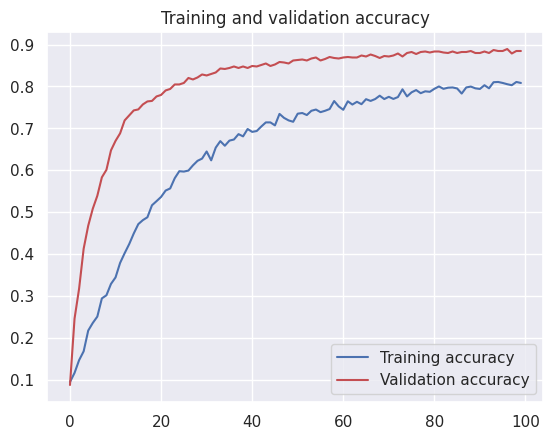

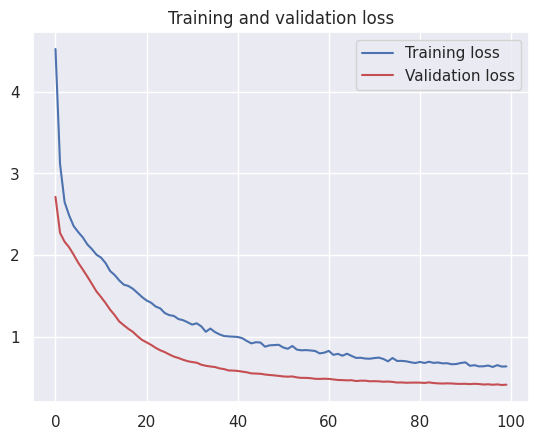

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

33/33 [==============================] - 23s 407ms/step
The first 5 predictions: ['bees', 'snail', 'moth', 'snail', 'weevil']


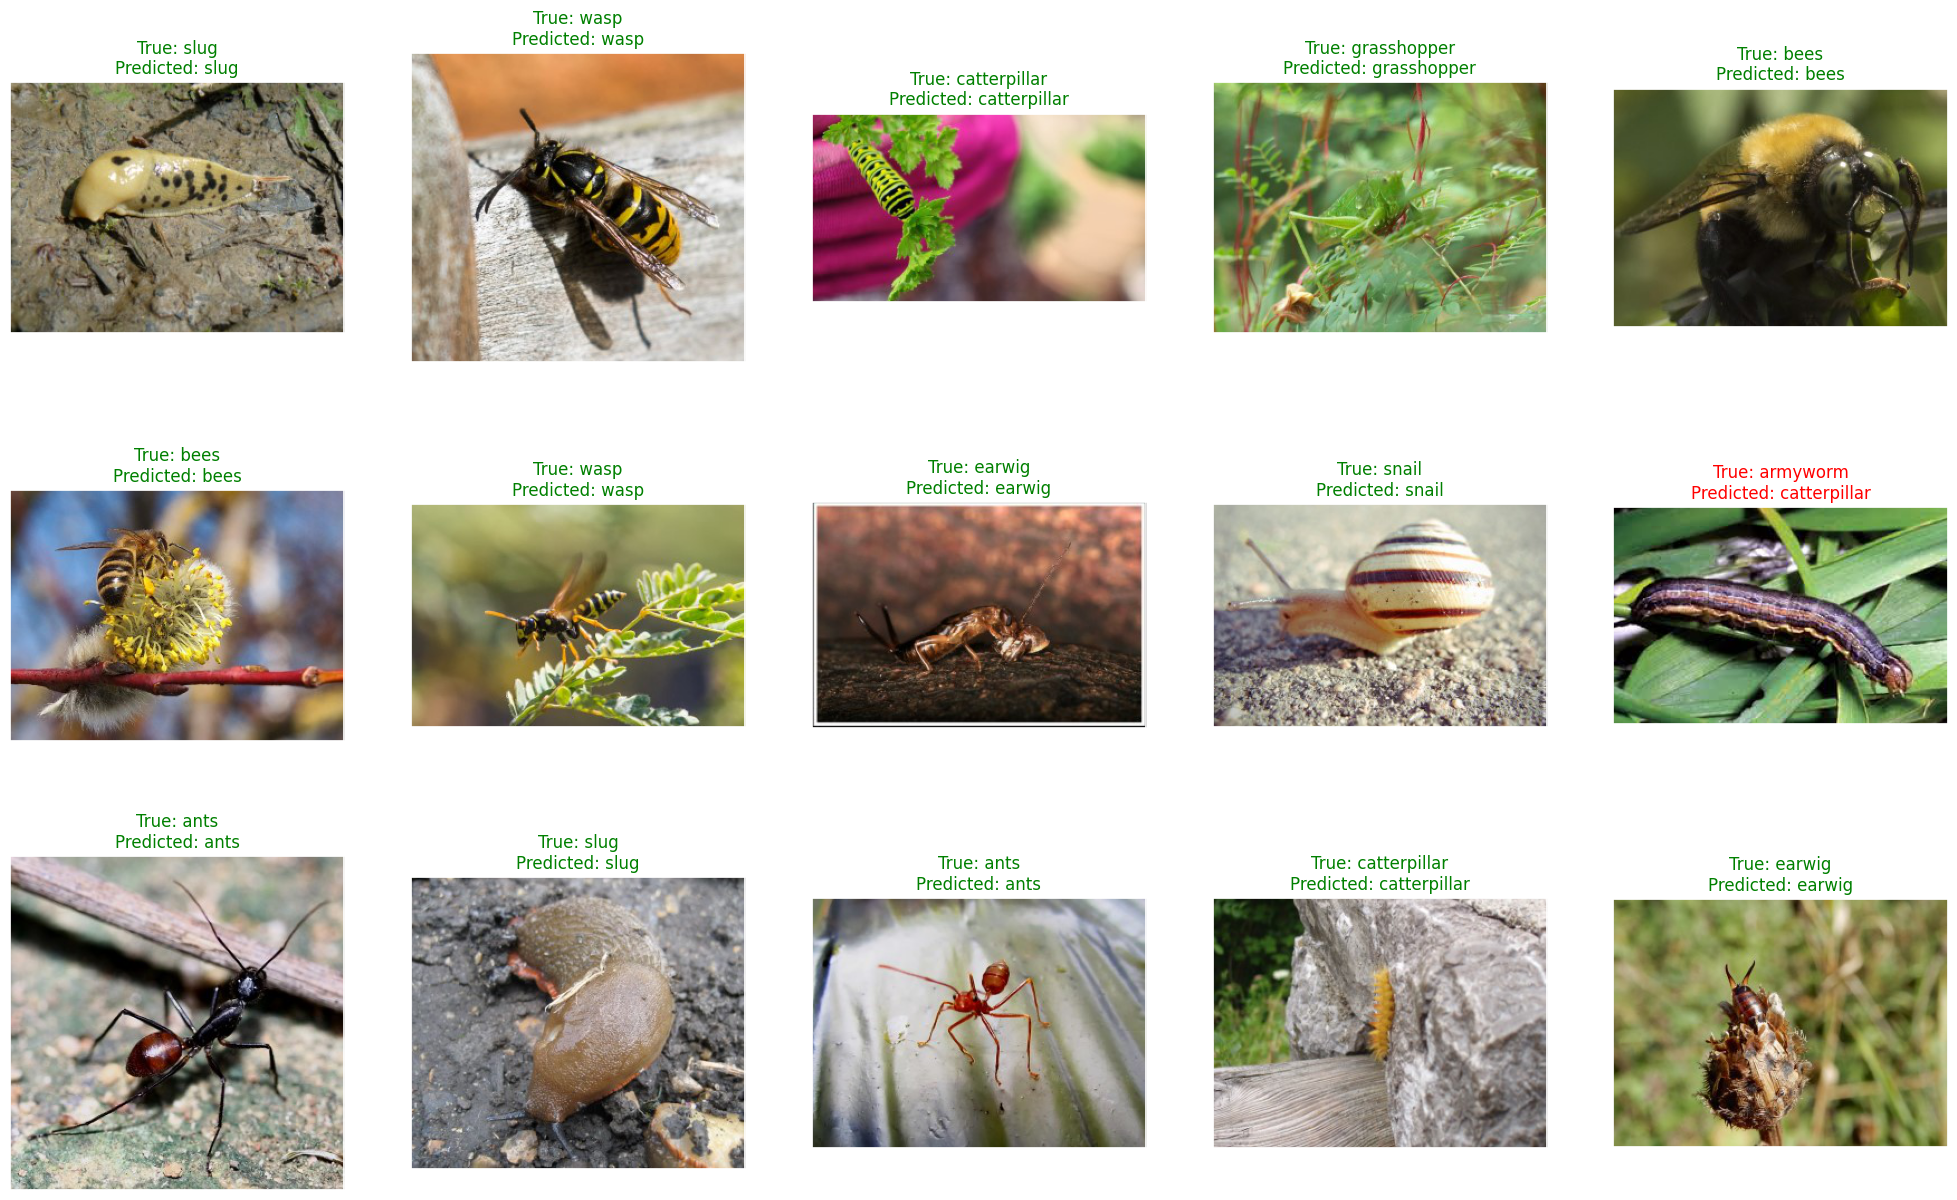

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        ants       0.96      0.99      0.98       101
    armyworm       1.00      0.07      0.12        15
        bees       0.84      0.97      0.90        98
      beetle       0.94      0.74      0.83        87
catterpillar       0.71      0.81      0.75        89
      earwig       0.85      0.80      0.83       101
 grasshopper       0.84      0.91      0.87        96
        moth       0.91      0.93      0.92        89
        slug       0.94      0.91      0.93        82
       snail       0.95      1.00      0.97        89
        wasp       0.95      0.86      0.91       111
      weevil       0.94      0.99      0.96        92

    accuracy                           0.89      1050
   macro avg       0.90      0.83      0.83      1050
weighted avg       0.90      0.89      0.88      1050



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
ants           0.961538  0.990099  0.975610   101.000000
armyworm       1.000000  0.066667  0.125000    15.000000
bees           0.840708  0.969388  0.900474    98.000000
beetle         0.941176  0.735632  0.825806    87.000000
catterpillar   0.705882  0.808989  0.753927    89.000000
earwig         0.852632  0.801980  0.826531   101.000000
grasshopper    0.836538  0.906250  0.870000    96.000000
moth           0.912088  0.932584  0.922222    89.000000
slug           0.937500  0.914634  0.925926    82.000000
snail          0.946809  1.000000  0.972678    89.000000
wasp           0.950495  0.864865  0.905660   111.000000
weevil         0.938144  0.989130  0.962963    92.000000
accuracy       0.889524  0.889524  0.889524     0.889524
macro avg      0.901959  0.831685  0.830566  1050.000000
weighted avg   0.895014  0.889524  0.884091  1050.000000

In [11]:
# make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-30-22b076d369ff>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


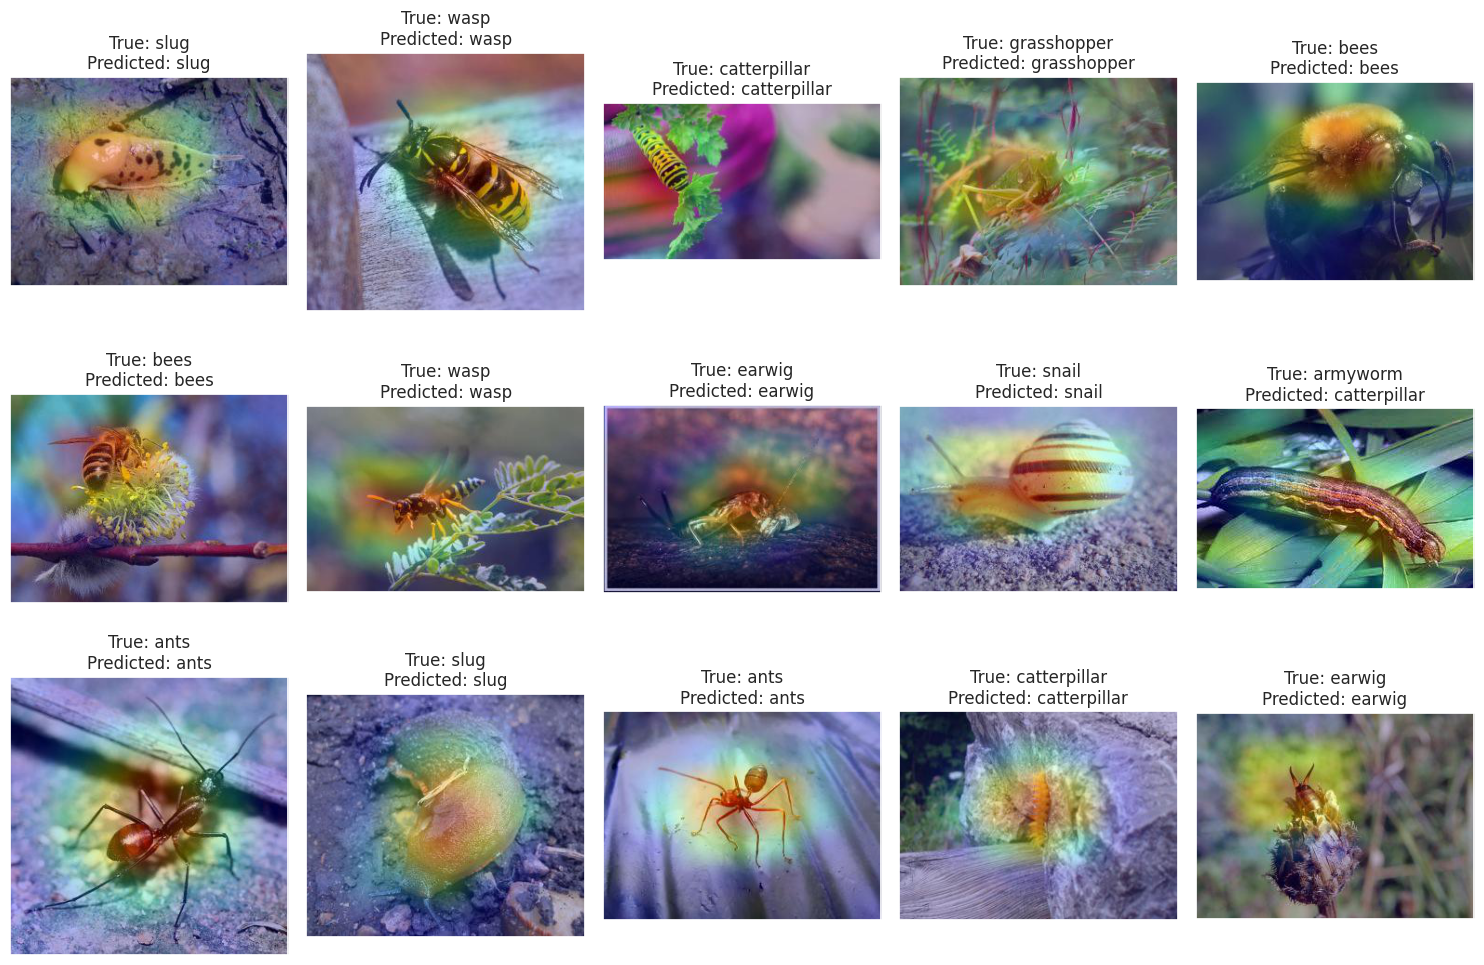

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save('saved_model/my_model')

In [ ]:
# Save the model .h5 format
model.save('model.h5')

In [ ]:
!ls saved_model/

my_model


In [ ]:
pip install tflite-runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.6 MB/s eta 0:00:00


In [ ]:
# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
tflite_model = converter.convert()

# Save the converted model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [23]:
######## Webcam Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 10/27/19
# Description: 
# This program uses a TensorFlow Lite model to perform object detection on a live webcam
# feed. It draws boxes and scores around the objects of interest in each frame from the
# webcam. To improve FPS, the webcam object runs in a separate thread from the main program.
# This script will work with either a Picamera or regular USB webcam.
#
# This code is based off the TensorFlow Lite image classification example at:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/python/label_image.py
#
# I added my own method of drawing boxes and labels using OpenCV.

# Import packages
import os
import argparse
import cv2
import numpy as np
import sys
import time
from threading import Thread
import importlib.util

# Define VideoStream class to handle streaming of video from webcam in separate processing thread
# Source - Adrian Rosebrock, PyImageSearch: https://www.pyimagesearch.com/2015/12/28/increasing-raspberry-pi-fps-with-python-and-opencv/
class VideoStream:
    """Camera object that controls video streaming from the Picamera"""
    def __init__(self,resolution=(640,480),framerate=30):
        # Initialize the PiCamera and the camera image stream
        self.stream = cv2.VideoCapture(0)
        ret = self.stream.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
        ret = self.stream.set(3,resolution[0])
        ret = self.stream.set(4,resolution[1])
            
        # Read first frame from the stream
        (self.grabbed, self.frame) = self.stream.read()

	# Variable to control when the camera is stopped
        self.stopped = False

    def start(self):
	# Start the thread that reads frames from the video stream
        Thread(target=self.update,args=()).start()
        return self

    def update(self):
        # Keep looping indefinitely until the thread is stopped
        while True:
            # If the camera is stopped, stop the thread
            if self.stopped:
                # Close camera resources
                self.stream.release()
                return

            # Otherwise, grab the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
	# Return the most recent frame
        return self.frame

    def stop(self):
	# Indicate that the camera and thread should be stopped
        self.stopped = True

# Define and parse input arguments
parser = argparse.ArgumentParser()
parser.add_argument('--modeldir', help='Folder the .tflite file is located in',
                    required=True)
parser.add_argument('--graph', help='Name of the .tflite file, if different than detect.tflite',
                    default='detect.tflite')
parser.add_argument('--labels', help='Name of the labelmap file, if different than labelmap.txt',
                    default='labelmap.txt')
parser.add_argument('--threshold', help='Minimum confidence threshold for displaying detected objects',
                    default=0.5)
parser.add_argument('--resolution', help='Desired webcam resolution in WxH. If the webcam does not support the resolution entered, errors may occur.',
                    default='1280x720')
parser.add_argument('--edgetpu', help='Use Coral Edge TPU Accelerator to speed up detection',
                    action='store_true')

args = parser.parse_args()

MODEL_NAME = args.modeldir
GRAPH_NAME = args.graph
LABELMAP_NAME = args.labels
min_conf_threshold = float(args.threshold)
resW, resH = args.resolution.split('x')
imW, imH = int(resW), int(resH)
use_TPU = args.edgetpu

# Import TensorFlow libraries
# If tflite_runtime is installed, import interpreter from tflite_runtime, else import from regular tensorflow
# If using Coral Edge TPU, import the load_delegate library
pkg = importlib.util.find_spec('tflite_runtime')
if pkg:
    from tflite_runtime.interpreter import Interpreter
    if use_TPU:
        from tflite_runtime.interpreter import load_delegate
else:
    from tensorflow.lite.python.interpreter import Interpreter
    if use_TPU:
        from tensorflow.lite.python.interpreter import load_delegate

# If using Edge TPU, assign filename for Edge TPU model
if use_TPU:
    # If user has specified the name of the .tflite file, use that name, otherwise use default 'edgetpu.tflite'
    if (GRAPH_NAME == 'detect.tflite'):
        GRAPH_NAME = 'edgetpu.tflite'       

# Get path to current working directory
CWD_PATH = os.getcwd()

# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,GRAPH_NAME)

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,MODEL_NAME,LABELMAP_NAME)

# Load the label map
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Have to do a weird fix for label map if using the COCO "starter model" from
# https://www.tensorflow.org/lite/models/object_detection/overview
# First label is '???', which has to be removed.
if labels[0] == '???':
    del(labels[0])

# Load the Tensorflow Lite model.
# If using Edge TPU, use special load_delegate argument
if use_TPU:
    interpreter = Interpreter(model_path=PATH_TO_CKPT,
                              experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
    print(PATH_TO_CKPT)
else:
    interpreter = Interpreter(model_path=PATH_TO_CKPT)

interpreter.allocate_tensors()

# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5

# Check output layer name to determine if this model was created with TF2 or TF1,
# because outputs are ordered differently for TF2 and TF1 models
outname = output_details[0]['name']

if ('StatefulPartitionedCall' in outname): # This is a TF2 model
    boxes_idx, classes_idx, scores_idx = 1, 3, 0
else: # This is a TF1 model
    boxes_idx, classes_idx, scores_idx = 0, 1, 2

# Initialize frame rate calculation
frame_rate_calc = 1
freq = cv2.getTickFrequency()

# Initialize video stream
videostream = VideoStream(resolution=(imW,imH),framerate=30).start()
time.sleep(1)

#for frame1 in camera.capture_continuous(rawCapture, format="bgr",use_video_port=True):
while True:

    # Start timer (for calculating frame rate)
    t1 = cv2.getTickCount()

    # Grab frame from video stream
    frame1 = videostream.read()

    # Acquire frame and resize to expected shape [1xHxWx3]
    frame = frame1.copy()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (width, height))
    input_data = np.expand_dims(frame_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'],input_data)
    interpreter.invoke()

    # Retrieve detection results
    boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
    classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0] # Class index of detected objects
    scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects

    # Loop over all detections and draw detection box if confidence is above minimum threshold

    object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
    label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
    label_ymin = max(0, labelSize[1] + 10) # Make sure not to draw label too close to top of window
    cv2.putText(frame, label, (0, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # Draw framerate in corner of frame
    cv2.putText(frame,'FPS: {0:.2f}'.format(frame_rate_calc),(30,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),2,cv2.LINE_AA)

    # All the results have been drawn on the frame, so it's time to display it.
    cv2.imshow('Object detector', frame)

    # Calculate framerate
    t2 = cv2.getTickCount()
    time1 = (t2-t1)/freq
    frame_rate_calc= 1/time1

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

# Clean up
cv2.destroyAllWindows()
videostream.stop()

usage: ipykernel_launcher.py [-h] --modeldir MODELDIR [--graph GRAPH]
                             [--labels LABELS] [--threshold THRESHOLD]
                             [--resolution RESOLUTION] [--edgetpu]
ipykernel_launcher.py: error: the following arguments are required: --modeldir


SystemExit: ignored

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
